In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np

import random
import h5py
from keras.datasets import cifar10
from keras.models import *
from keras.layers import *
from keras.layers.core import *
from keras.layers.normalization import *
from keras.optimizers import *
from keras.callbacks import *
from keras import backend as K
from keras.regularizers import *
import theano.tensor as T
import theano
from theano.tensor.shared_randomstreams import RandomStreams
from sklearn import metrics
from skimage.measure import compare_ssim
from scipy.misc import toimage
from sklearn.preprocessing import *

import os
import random
import time
from skimage import io, exposure, feature, color, transform
import matplotlib
import matplotlib.pyplot as plt
import glob

import scipy.signal as sig
import operator
import math

# for reproducibility
np.random.seed(1337) 
random.seed(1337)

Using Theano backend.
Using gpu device 0: GeForce GTX 690 (CNMeM is disabled, cuDNN 5105)


In [2]:
# parameters for sliding window, and window function (Hann)
STEP_SIZE = 480
OVERLAP_SIZE = 32
WINDOW_SIZE = STEP_SIZE + OVERLAP_SIZE
OVERLAP_FUNC = sig.hann(OVERLAP_SIZE * 2)

# directory that contains TIMIT files
TIMIT_DIR = "/home/sri/Desktop/timit"

# randomly shuffle data before partitioning into training/validation?
RANDOM_SHUFFLE = True

# sample rate of input file (used in MFCC calculation)
SAMPLE_RATE = 16000

In [3]:
from load_TIMIT import *
from windowingFunctions import *
from utility import *

In [4]:
# read in 100 WAVs from TIMIT training set
rawWaveforms = load_TIMIT_train(TIMIT_DIR, 1000)

Reading in .wav files...


In [5]:
'''
# waveform preprocessing
def preprocessWaveform(waveform):   
    return waveform, ()
   
def unpreprocessWaveform(waveform, params):
    return waveform



# window preprocessing
def preprocessWindows(windows):
    # scale window between -1 and 1
    processed = np.copy(windows)
   
    mn = np.min(processed, axis = 1)
    mx = np.max(processed, axis = 1)

    maxabs = np.maximum(np.abs(mn), np.abs(mx))

    for i in xrange(0, processed.shape[0]):
        processed[i] /= maxabs[i]
    #processed *= 0.98
   
    #processed = (processed + 1.0) / 2.0
   
    return processed, (maxabs,)

def unpreprocessWindows(windows, params):
    # scale window from [-1, 1] to [-32768, 32768]
    scl = params[0]
   
    unprocessed = np.copy(windows)
    #unprocessed /= 0.98
   
    #nprocessed = (unprocessed * 2.0) - 1.0
   
    for i in xrange(0, unprocessed.shape[0]):
        unprocessed[i] *= scl[i]

    return unprocessed
#'''

#'''
# waveform preprocessing
def preprocessWaveform(waveform):
    # scale window between -1 and 1
    mn = np.min(waveform)
    mx = np.max(waveform)
    maxabs = np.maximum(np.abs(mn), np.abs(mx))
        
    return np.copy(waveform) / maxabs, (maxabs,)
   
def unpreprocessWaveform(waveform, params):
    return np.copy(waveform) * params[0]



# window preprocessing
def preprocessWindows(windows):
    return windows, ()

def unpreprocessWindows(windows, params):
    return windows
#'''

In [6]:
# waveform preprocessing
processedWaveforms = np.copy(rawWaveforms)

# we maximize the volume of every waveform
for i in xrange(0, len(processedWaveforms)):
    processedWaveforms[i], _ = preprocessWaveform(rawWaveforms[i])


In [7]:
# extract windows
rawWindows = extractWindowsMultiple(processedWaveforms, STEP_SIZE, OVERLAP_SIZE,
                                    collapse = True)

# randomly shuffle data
if (RANDOM_SHUFFLE):
    rawWindows = np.random.permutation(rawWindows)

print "Raw windows shape: ", rawWindows.shape
print "Max: ", np.amax(rawWindows)
print "Min: ", np.amin(rawWindows)

Raw windows shape:  (101135, 512)
Max:  1.0
Min:  -1.0


In [8]:
# data augmentation goes here, at some point
augWindows = np.copy(rawWindows)

print "Aug windows shape: ", augWindows.shape

Aug windows shape:  (101135, 512)


In [9]:
processedWindows, pwParams = preprocessWindows(augWindows)

In [10]:
# reshape into vector form
processedWindows = np.reshape(processedWindows, (processedWindows.shape[0], WINDOW_SIZE, 1))

In [11]:
print processedWindows.shape

print np.mean(processedWindows, axis=None)
print np.std(processedWindows, axis=None)
print np.min(processedWindows, axis = None)
print np.max(processedWindows, axis = None)

(101135, 512, 1)
9.77603e-07
0.099766
-1.0
1.0


In [12]:
class CodeRound(T.Op):
    # properties attribute
    __props__ = ()
    
    def __init__(self, nbins):
        self.nbins = nbins
        super(CodeRound, self).__init__()
        
    def make_node(self, x):
        assert hasattr(self, '_props'), "Your version of theano is too old to support __props__."
        x = T.as_tensor_variable(x)
        return theano.Apply(self, [x], [x.type()])
    
    def perform(self, node, inputs, output_storage):
        x, = inputs
        z, = output_storage
        
        s = (x + 1.0) / 2.0
        s = np.round(s * float(self.nbins - 1)) / float(self.nbins - 1)
        s = (s * 2.0) - 1.0
        
        z[0] = s
    
    def grad(self, input, output_gradients):
        # pass through gradients unchanged
        x, = input
        g, = output_gradients
        return [g]
        
    def infer_shape(self, node, i0_shapes):
        # output shape is same as input shape
        return i0_shapes

In [13]:
class PhaseShiftUp1D(Layer):
    """ PhaseShiftUp1D
    Takes vector of size: B x S x nF
    And returns vector: B x nS x F
    """
    def __init__(self, n, **kwargs):
        super(PhaseShiftUp1D, self).__init__(**kwargs)
        self.n = n
    
    def build(self, input_shape):
        # no trainable parameters
        self.trainable_weights = []
    
    def call(self, x, mask=None):
        r = T.reshape(x, (x.shape[0], x.shape[1], x.shape[2] / self.n, self.n))
        r = T.transpose(r, (0, 1, 3, 2))
        r = T.reshape(r, (x.shape[0], x.shape[1] * self.n, x.shape[2] / self.n))
        return r

    def get_output_shape_for(self, input_shape):
        return (input_shape[0], input_shape[1] * self.n, input_shape[2] / self.n)
    
    def get_config(self):
        config = {'n' : self.n}
        base_config = super(PhaseShiftUp1D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [14]:
def linear_upsample_1d(x):
    r = T.repeat(x, 2, axis = 1)
    s = T.roll(r, -1, axis = 1)
    u = ((r[:, :-1] + s[:, :-1]) / 2.0)
    u = T.concatenate((u, r[:, -1:]), axis = 1)
    return u

def linear_upsample_shape(shape):
    return (shape[0], shape[1] * 2, shape[2])

# linear upsampling "layer"
def LinearUpSampling1D():
    return Lambda(linear_upsample_1d, output_shape = linear_upsample_shape)

In [15]:
from scipy.fftpack import dct as scidct

# ====================================================================
#  DCT (Discrete Cosine Transform)
# ====================================================================

# generate square dct matrix
#     how to use: generate n-by-n matrix M. then, if you have a signal w, then:
#                 dct(w) = M * w
#     where w must be n-by-1
#
#     backed by scipy
def generate_dct_mat(n, norm = 'ortho'):
    return (scidct(np.eye(n), norm = norm))

# DCT matrix is precomputed at start of program
dctMat = generate_dct_mat(WINDOW_SIZE)
th_dctMat = K.variable(dctMat)

# given a (symbolic Theano) array of size M x WINDOW_SIZE
#     this returns an array M x WINDOW_SIZE where every one of the M samples has been independently
#     filtered by the DCT
def theano_dct(x, dctMat = None):
    global th_dctMat
    
    if (dctMat is None):
        dctMat = th_dctMat
        
    # reshape x into 2D array, and perform appropriate matrix operation
    reshaped_x = x.reshape((1, x.shape[0], x.shape[1]))

    result = T.tensordot(dctMat, reshaped_x, [[0], [2]])
    result = result.reshape((result.shape[0], result.shape[2])).T

    return result

# M x WINDOW_SIZE x 1 => M x WINDOW_SIZE x 1
def theano_batch_dct(x):
    result = theano_dct(x)
    reshaped_result = result.reshape((result.shape[0], result.shape[1], 1))

    return reshaped_result


def upper_dct_loss(y_true, y_pred):
    dct_true = theano_batch_dct(y_true)
    dct_pred = theano_batch_dct(y_pred)
    cutoff_idx = WINDOW_SIZE / 2
    
    # compute MAE in frequency domain
    error = K.mean(K.abs(dct_pred[:, :cutoff_idx] - dct_true[:, :cutoff_idx]), axis = 1)
    return error

In [16]:
from keras.activations import softmax, sigmoid
from scipy.fftpack import dct, idct

# lambda to compute MSE between 2 vectors
def mse_lambda(vects):
    x, y = vects
    return K.mean(K.square(x - y))

# freeze weights for stacked training
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val

# ====================================================
# PARAMETERS FOR AUTOENCODER STRUCTURE
# ====================================================
BNORM_GEN = False
BNORM_DSC = False

NBINS = 201
TIMES_DOWNSAMPLE = 2

NCHAN = 32
FILT_SIZE = 9
FILT_MID = FILT_SIZE / 2 + 1
OUT_CHANS = 1

NUM_RES_BLOCKS = 4

input_dim = (WINDOW_SIZE, 1)
input_size = np.prod(input_dim)
bottleneck_size = WINDOW_SIZE / int(2 ** TIMES_DOWNSAMPLE)

res_init = 'glorot_normal'

def activation():
    return LeakyReLU(0.2)

# ----------------------------------------------------
# weight initializers
# ----------------------------------------------------

# convolutional layers have weight matrices of shape:
#     (filter_length, 1, input_dim, nb_filter)
# and biases of size (nb_filter,)

# weights for an "replication convolution" (which just
# replicates the input across all channels)
#     filter of length FILT_SIZE, going from 1 channel to NCHAN
def replicate_conv():
    weights = np.zeros((FILT_SIZE, 1, 1, NCHAN))
    weights[FILT_MID] = np.ones((1, 1, NCHAN))
    #weights += np.random.uniform(-0.005, 0.005, weights.shape)
    biases = np.zeros((NCHAN,))
    return [weights, biases]

# weights for an "average convolution" (which just
# replicates the input across all channels)
#     filter of length 1, going from NCHAN channels to 1
def average_conv(sz):
    mid = sz / 2 + 1
    if (sz == 1): mid = 0

    weights = np.zeros((sz, 1, NCHAN, 1))
    weights[mid] = np.ones((1, NCHAN, 1)) / float(NCHAN)
    #weights += np.random.uniform(-0.005, 0.005, weights.shape)
    biases = np.zeros((1,))
    return [weights, biases]

# weights for a "identity" convolution (by default,
# does nothing to its input)
#     filter of length FILT_SIZE, going from NCHAN to NCHAN
#     (when combined with subsampling, this is a nearest-neighbor
#      downsample)
def identity_conv():
    weights = np.zeros((FILT_SIZE, 1, NCHAN, NCHAN))
    weights[FILT_MID, 0] = np.eye(NCHAN)
    #weights += np.random.uniform(-0.005, 0.005, weights.shape)
    biases = np.zeros((NCHAN,))
    return [weights, biases]


# weights for a "phase shift up" convolution (by default,
# performs an upsample)
#     filter of length FILT_SIZE, going from NCHAN to NCHAN * 2
def shift_up_conv():
    weights = np.zeros((FILT_SIZE, 1, NCHAN, NCHAN * 2))
    weights[FILT_MID, 0] = np.repeat(np.eye(NCHAN), 2, axis = 1)
    #weights += np.random.uniform(-0.01, 0.01, weights.shape)
    biases = np.zeros((NCHAN * 2,))
    return [weights, biases]

# random identity weights, plus some noise
def identity_mat(n):
    weights = np.eye(n) + np.random.uniform(-0.01, 0.01, (n, n))
    biases = np.zeros(n)
    return [weights, biases]

# weights for DCT and IDCT (can use in a Dense layer, perhaps)
def dct_weights(n):
    weights = dct(np.eye(n), norm = 'ortho')
    biases = np.zeros(n)
    return [weights, biases]

def idct_weights(n):
    weights = idct(np.eye(n), norm = 'ortho')
    biases = np.zeros(n)
    return [weights, biases]


# ----------------------------------------------------
# blocks of network
# ----------------------------------------------------

# residual block, going from NCHAN to NCHAN channels
def residual_block():
    def f(input):
        shortcut = input
        
        res = Convolution1D(NCHAN, FILT_SIZE, border_mode = 'same',
                          init = res_init, activation = 'linear',
                          bias = True)(input)
        res = activation()(res)
        if (BNORM_GEN): res = BatchNormalization(axis = 1)(res)
        res = Convolution1D(NCHAN, FILT_SIZE, border_mode = 'same',
                          init = res_init, activation = 'linear',
                          bias = True)(res)
        
        m = merge([shortcut, res], mode = 'sum')
        return m
    
    return f


# increase number of channels from 1 to NCHAN via convolution
def channel_increase_block():
    def f(input):
        out = Convolution1D(NCHAN, FILT_SIZE, border_mode = 'same',
                              activation = 'linear',
                              init = res_init,
                              bias = True)(input)
        if (BNORM_GEN): out = BatchNormalization(axis = 1)(out)
        out = activation()(out)
        
        return out
        
    return f


# downsample the signal 2x
def downsample_block():
    def f(input):
        shortcut = AveragePooling1D(2)(input)
        
        res = Convolution1D(NCHAN, FILT_SIZE, border_mode = 'same',
                              init = res_init, activation = 'linear',
                              subsample_length = 2, bias = True)(input)
        if (BNORM_GEN): res = BatchNormalization(axis = 1)(res)
        res = activation()(res)
        
        m = merge([shortcut, res], mode = 'sum')
        return m
    
    return f


# upsample the signal 2x
def upsample_block():
    def f(input):
        upsampled = LinearUpSampling1D()(input)
        
        res = Convolution1D(NCHAN * 2, FILT_SIZE, border_mode = 'same',
                              init = res_init, activation = 'linear',
                              bias = True)(input)
        if (BNORM_GEN): res = BatchNormalization(axis = 1)(res)
        res = activation()(res)
        res = PhaseShiftUp1D(2)(res)
        
        m = merge([upsampled, res], mode = 'sum')
        return m
    
    return f



    
# ---------------------------------------------------------------------------
# autoencoder: takes an audio window, compresses it, and tries to reconstruct it
# ---------------------------------------------------------------------------
def autoencoder_structure(dim):
    enc_input = Input(shape = dim)
    enc = Reshape(dim, input_shape = dim)(enc_input)
    
    #enc = Reshape((WINDOW_SIZE,))(enc)
    #enc = Dense(WINDOW_SIZE, init = 'identity')(enc)
    #enc = Reshape((WINDOW_SIZE, 1))(enc)
    
    # increase number of channels via convolution
    enc = channel_increase_block()(enc)
    
    # residual blocks
    for i in xrange(0, NUM_RES_BLOCKS):
        enc = residual_block()(enc)
    
    # residual downsampling
    down = enc
    res = enc
    
    for i in xrange(0, TIMES_DOWNSAMPLE):
        down = AveragePooling1D(2)(down)
        
    
    res = Convolution1D(NCHAN, FILT_SIZE, border_mode = 'same',
                        init = res_init, activation = 'linear',
                        bias = True)(res)
    res = activation()(res)
    for i in xrange(0, TIMES_DOWNSAMPLE): 
        res = downsample_block()(res)
    
    enc = merge([down, res], mode = 'sum') 
    
    # convolution across feature maps
    enc = Convolution1D(OUT_CHANS, FILT_SIZE, border_mode = 'same',
                        weights = average_conv(FILT_SIZE), activation = 'linear',
                        bias = True)(enc)
    
    enc = Reshape((bottleneck_size * OUT_CHANS,))(enc)
    
    enc = Activation('tanh')(enc)
    enc = Lambda(lambda x : CodeRound(NBINS)(x))(enc)
    
    enc = Model(input = enc_input, output = enc)
    
    
    
    
    
    dec_input = Input(shape = (bottleneck_size * OUT_CHANS,))
    dec = Reshape((bottleneck_size * OUT_CHANS,), input_shape = (bottleneck_size * OUT_CHANS,))(dec_input)
    
    dec = Reshape((bottleneck_size, OUT_CHANS,))(dec)
    
    # increase number of channels via convolution
    dec = channel_increase_block()(dec)
        
    # residual upsampling
    up = dec
    res = dec
    
    for i in xrange(0, TIMES_DOWNSAMPLE):
        up = LinearUpSampling1D()(up)
    
    res = Convolution1D(NCHAN, FILT_SIZE, border_mode = 'same',
                        init = res_init, activation = 'linear',
                        bias = True)(res)
    res = activation()(res)
    for i in xrange(0, TIMES_DOWNSAMPLE):
        res = upsample_block()(res)
    
    dec = merge([up, res], mode = 'sum')
    
    # residual blocks
    for i in xrange(0, NUM_RES_BLOCKS):
        dec = residual_block()(dec)
    
    # convolution across feature maps
    dec = Convolution1D(1, FILT_SIZE, border_mode = 'same',
                        weights = average_conv(FILT_SIZE), activation = 'linear',
                        bias = True)(dec)
    dec = Activation('tanh')(dec)
    
    #dec = Reshape((WINDOW_SIZE,))(dec)
    #dec = Dense(WINDOW_SIZE, init = 'identity')(dec)
    #dec = Reshape((WINDOW_SIZE, 1))(dec)
    
    dec = Model(input = dec_input, output = dec)
    
    return enc, dec

# ---------------------------------------------------------------------------
# discriminator: tries to differentiate between original and reconstructed samples
# ---------------------------------------------------------------------------
DSC_FILTS = 32
DSC_DENSE = 16
DSC_FILT_SIZE = 9
def discriminator_structure(dim):
    dsc_input = Input(shape = dim)
    dsc = Reshape(dim, input_shape = dim)(dsc_input)
    
    dsc = Convolution1D(DSC_FILTS, DSC_FILT_SIZE, border_mode='same',
                        init = res_init, activation = 'linear',
                        bias = True)(dsc)
    
    for i in xrange(0, 3):
        shortcut = dsc
        res = dsc
        
        res = Convolution1D(DSC_FILTS, DSC_FILT_SIZE, border_mode='same',
                            init = res_init,
                            activation = 'linear')(res)
        res = LeakyReLU(0.3)(res)
        
        res = Convolution1D(DSC_FILTS, DSC_FILT_SIZE, border_mode='same',
                            init = res_init,
                            activation = 'linear')(res)
        
        dsc = merge([shortcut, res], mode = 'sum')
        dsc = AveragePooling1D(2)(dsc)
        
    dsc = Flatten()(dsc)
    
    dsc = Dense(DSC_DENSE, init = res_init)(dsc)
    dsc = LeakyReLU(0.3)(dsc)
    
    dsc = Dense(1, activation = 'linear', init = res_init)(dsc)
    
    dsc = Model(input = dsc_input, output = dsc)
    return dsc, None


# construct autoencoder to be used in adversarial training
ac_input = Input(shape = input_dim)
ac_enc, ac_dec = autoencoder_structure(input_dim)
ac_embedding = ac_enc(ac_input)
ac_reconstructed = ac_dec(ac_embedding)

autoencoder = Model(input = [ac_input], output = [ac_reconstructed])
autoencoder.compile(loss = 'mean_squared_error', optimizer = Adam())

# construct discriminator: regular
dsc_input_dim = (WINDOW_SIZE, 1)
dsc_input = Input(shape = input_dim)
dsc_struct, dscfeat_struct = discriminator_structure(dsc_input_dim)
dsc_label = dsc_struct(dsc_input)
ac_dsc_label = dsc_struct(ac_reconstructed)

# get feature loss at intermediate layer of discriminator
#dscfeat_inp = dscfeat_struct(ac_input)
#dscfeat_rec = dscfeat_struct(ac_reconstructed)
#dscfeat_mse = Lambda(mse_lambda, output_shape = (1,))([dscfeat_inp, dscfeat_rec])


    
# ------------------------------------------------------------------
# PARZEN ENTROPY ESTIMATION
# ------------------------------------------------------------------
# the Parzen kernel is a zero-centered gaussian with bin-width standard deviation
std = (1.0 / (NBINS - 1))
norm = 1.0 / math.sqrt(2.0 * 3.14159 * std * std)
den = (2.0 * std * std)

def parzen_kernel(x):
    num = K.square(x)
    return norm * K.exp(-num / den)

# we use 10,000 samples to create our entropy estimate
N = 10000
log_2 = math.log(2.0)
bins = K.variable(np.linspace(-1.0, 1.0, NBINS))
r_bins = K.repeat_elements(bins.reshape((NBINS, 1)), N, 1)

# we increase the weight of the entropy loss over time while
# training
entropy_weight = K.variable(0.0, name = 'entropy_weight')
max_entropy_weight = 1.0
entropy_weight_rate = 0.1

def entropy_estimate(placeholder, code):
    # if there are less than N samples in this batch, we just use however much data
    # we have
    flt = K.flatten(code)
    end_idx = K.minimum(flt.shape[0], N)
    
    ref = flt[:end_idx]
    r_ref = K.repeat_elements(ref.reshape((1, end_idx)), NBINS, 0)

    r_kern = parzen_kernel(r_ref - r_bins[:, :end_idx])
    r_kern = K.sum(r_kern, axis = 1)
    r_kern /= K.sum(r_kern)

    # clip to a low value so the log doesn't underflow
    ent = K.clip(r_kern, 1e-9, 1.0)
    ent = -K.sum(ent * K.log(ent) / log_2)
    return ent#ent * entropy_weight

# ------------------------------------------------------------------
# WASSERSTEIN GAN LOSS
# ------------------------------------------------------------------
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)

# ------------------------------------------------------------------
# RMSE (suffers from bad derivative behavior. use MAE instead)
# ------------------------------------------------------------------
def rmse(y_true, y_pred):
    mse = K.mean(K.square(y_pred - y_true))
    mse = K.clip(mse, 1e-10, 1000000.0)
    return K.sqrt(mse)


# compile model
loss_weights = [400.0, 1.0]
loss_functions = ['mae', 'mae']
n_recons = 1
n_discrim = 1
n_code = 0
assert(n_recons + n_discrim + n_code == len(loss_weights))
assert(len(loss_weights) == len(loss_functions))


make_trainable(autoencoder, False)
discriminator = Model(input = [dsc_input], output = [dsc_label])
discriminator.compile(loss = ['mae'], optimizer = Adam())
discriminator.summary()

autoencoder.summary()

make_trainable(discriminator, False)
make_trainable(autoencoder, True)
model = Model(input = [ac_input], output = [ac_reconstructed] * n_recons + \
                                           [ac_dsc_label] * n_discrim + \
                                           [ac_embedding] * n_code)
model.compile(loss = loss_functions,
              loss_weights = loss_weights,
              optimizer = Adam())
model.summary()



X_train = np.copy(processedWindows)
ntrain = X_train.shape[0]
discrim_epoch = False


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, 512, 1)        0                                            
____________________________________________________________________________________________________
model_4 (Model)                  (None, 1)             88609       input_4[0][0]                    
Total params: 88,609
Trainable params: 88,609
Non-trainable params: 0
____________________________________________________________________________________________________
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 512, 1)        0                                            
_____________________

In [17]:
def test_discriminator(discriminator, autoencoder, X, y, verbose = True):
    # verify discriminator was trained properly
    y_hat = discriminator.predict(X)
    y_hat[y_hat >= 0.5] = 1
    y_hat[y_hat < 0.5] = 0

    n_total = y.shape[0]
    n_correct = np.sum(np.ravel(y_hat) == y)

    acc = n_correct * 100.0 / n_total
    if (verbose):
        print "Discriminator accuracy: %0.02f pct (%d of %d) right"%(acc, n_correct, n_total)
    return acc

In [18]:
def autoencoderTest(waveFilename, prefix, autoencoder, verbose = True):
    [rate, data] = sciwav.read(waveFilename)
    data = data.astype(np.float32)
    processedWave, wparams = preprocessWaveform(data)
    windows = extractWindows(processedWave, STEP_SIZE, OVERLAP_SIZE)
    

    # first, write desired reconstruction
    transformed, tparams = preprocessWindows(windows)
    if (verbose):
        print transformed.shape
    
    desired = unpreprocessWindows(transformed, tparams)
    desired = reconstructFromWindows(desired, OVERLAP_SIZE, OVERLAP_FUNC)
    desired = unpreprocessWaveform(desired, wparams)
    desired = np.clip(desired, -32767, 32767)
    #sciwav.write(prefix + "_res_desired.wav", rate, desired.astype(np.int16))
    
    # then, run NN on transformed windows
    transformed, tparams = preprocessWindows(windows)
    
    transformed = np.reshape(transformed, (transformed.shape[0], WINDOW_SIZE, 1))
    autoencOutput = autoencoder.predict(transformed, batch_size = 128, verbose = (1 if verbose else 0))
    if (verbose):
        print autoencOutput.shape
    autoencOutput = np.reshape(autoencOutput, (autoencOutput.shape[0], WINDOW_SIZE))
    
    if (verbose):
        print autoencOutput.shape
    recons = unpreprocessWindows(autoencOutput, tparams)
    recons = reconstructFromWindows(recons, OVERLAP_SIZE, OVERLAP_FUNC)
    recons = unpreprocessWaveform(recons, wparams)
    recons = np.clip(recons, -32767, 32767)
    
    sciwav.write(prefix + "_output.wav", rate, recons.astype(np.int16))
    
    metrics = [
        np.max(desired),
        np.min(desired),
        np.max(recons),
        np.min(recons),
        mse(recons, desired),
        avgErr(recons, desired)
    ]
    
    if (verbose):
        print "Max/min desired:", metrics[0], metrics[1]
        print "Max/min recons: ", metrics[2], metrics[3]
        print waveFilename, " mse: ", metrics[4]
        print waveFilename, " avg err: ", metrics[5]
        
    return metrics

In [19]:
autoencoderTest("./SA1.WAV", "SA1_res_uninit_", autoencoder)

(112, 512)
112/112 [==============================] - 0s
(112, 512, 1)
(112, 512)
Max/min desired: 4899.0 -4013.0
Max/min recons:  22.781 -2.58236e-06
./SA1.WAV  mse:  154569.0
./SA1.WAV  avg err:  210.381


[4899.0, -4013.0, 22.780991, -2.5823574e-06, 154569.02, 210.38132]

In [20]:
# interleave numpy arrays of the same size along the first axis
def interleave(arr):    
    num = len(arr)
    
    r = np.empty(arr[0].shape)
    r = np.repeat(r, num, axis = 0)
    
    for i in xrange(0, num):
        r[i::num] = arr[i]
    
    return r

In [21]:
np.set_printoptions(formatter={'float_kind':'{:4f}'.format})

BATCH_SIZE = 128
NUM_BATCHES = ntrain / BATCH_SIZE
NUM_EPOCHS = 40

DSC_CLAMP_RANGE = 0.01

lead = "    "
d_loss = 0.0
a_losses = []
d_acc = 0.0
discrim_train_y = np.concatenate((np.ones(ntrain), np.zeros(ntrain)))

for epoch in range(NUM_EPOCHS):
    print "Epoch " + str(epoch + 1) + ":"

    # present batches randomly each epoch
    lis = range(0, ntrain, BATCH_SIZE)
    random.shuffle(lis)
    
    # keep track of start time and current batch #
    i = 0
    startTime = time.time()
    for idx in lis:
        batch = X_train[idx:idx+BATCH_SIZE, :,  :]
        nbatch = batch.shape[0]
        
        a_losses = ["autoencoder not training"]
        d_loss = "discriminator not training"

        
        # train autoencoder ("generator")
        make_trainable(autoencoder, True)
        make_trainable(discriminator, False)

        a_y = [batch] * n_recons + \
              [np.ones(nbatch)] * n_discrim + \
              [np.zeros(nbatch)] * n_code
        a_losses = model.train_on_batch(batch, a_y)
        
        
        if (n_discrim > 0):
            # train discriminator
            make_trainable(autoencoder, False)
            make_trainable(discriminator, True)
            
            # clip discriminator weights
            #for l in discriminator.layers:
            #    weights = l.get_weights()
            #    weights = [np.clip(w, -DSC_CLAMP_RANGE, DSC_CLAMP_RANGE) for w in weights]
            #    l.set_weights(weights)
            
            generated = autoencoder.predict(batch)
            discrim_batch_X = interleave([batch, generated])
            discrim_batch_y = interleave([np.ones(nbatch), np.zeros(nbatch)])

            d_loss = discriminator.train_on_batch(discrim_batch_X, discrim_batch_y)
        
        # print statistics every 10 batches so we know stuff is still going down
        if (i % 10 == 0):
            printStr = "        \r" + lead + str(i * BATCH_SIZE) + ": " + str(d_loss) + " "
            print printStr,
            
            loss_arr = np.asarray(a_losses)
            print loss_arr,
            
            if (len(loss_weights) > 1 and len(loss_arr) > 1):
                for w in xrange(0, len(loss_weights)):
                    loss_arr[w + 1] *= loss_weights[w]
                print loss_arr,
            
        i += 1
    print ""
    
    # print elapsed time for epoch
    elapsed = time.time() - startTime
    print lead + "Total time for epoch: " + str(elapsed) + "s"   
    
    # ---------------------------------------------------------
    # evaluate discriminator on random samples every epoch
    # ---------------------------------------------------------
    startTime = time.time()
    print lead + "----------------"
    if (n_discrim > 0):
        NUM = 200
        rows = np.random.randint(X_train.shape[0], size = NUM)
        generated = autoencoder.predict(X_train[rows, :], verbose = 0)
        d_X = np.concatenate((X_train[rows, :], generated))
        d_y = np.concatenate((np.ones(NUM), np.zeros(NUM)))
        d_acc = test_discriminator(discriminator, autoencoder,
                                   d_X, d_y, verbose = False)

        print lead + "Evaluated the discriminator: " + str(d_acc) + "% d_acc"
        elapsed = time.time() - startTime
        print lead + "Total time for evaluation: " + str(elapsed) + "s"
    else:
        print lead + "No discriminator"
    
    
    # ---------------------------------------------------------
    # generate code histogram from said random samples
    # ---------------------------------------------------------
    NUM = 200
    rows = np.random.randint(X_train.shape[0], size = NUM)
    code = ac_enc.predict(X_train[rows, :], verbose = 0)
    
    print lead + "----------------"
    print lead + "Code histogram:"
    scalars = code.flatten()
    
    b = np.linspace(-1.0, 1.0, NBINS + 1)
    hist = np.histogram(scalars, bins = b)
    sample_hist_probs = hist[0].astype('float32')
    sample_hist_bins = hist[1].astype('float32')
    sample_hist_probs /= np.sum(sample_hist_probs)

    entropy = 0
    for i in sample_hist_probs:
        if (i < 1e-4): continue
        entropy += i * math.log(i, 2)
    entropy = -entropy
    
    zero_prob = sample_hist_probs[NBINS / 2]
    zero_prob = np.clip(zero_prob, 0.001, 0.999)
    mask_entropy = -(zero_prob * math.log(zero_prob, 2) + (1.0 - zero_prob) * math.log(1.0 - zero_prob, 2))
    
    print "       Entropy:", entropy
    print "       Zero prob:", sample_hist_probs[NBINS / 2]
    print "       Mask entropy:", mask_entropy
    print "       Pct. in last bins:", sample_hist_probs[0] + sample_hist_probs[-1]
    
    nnz = 0.0
    for i in xrange(0, code.shape[0]):
        r = np.round(code[i] * 1000.0) / 1000.0
        nnz += np.count_nonzero(r)
    nnz /= code.shape[0]
    print "       Avg # nonzero elts:", nnz
    
    # ---------------------------------------------------------
    # evaluate autoencoder on real data evey epoch
    # ---------------------------------------------------------
    startTime = time.time()
    print lead + "----------------"
    
    print lead + "Evaluating autoencoder..."
    metrics = autoencoderTest("./SA1.WAV", "SA1_res_reg_train_epoch" + str(epoch+1), autoencoder, verbose = False)
    
    print lead + "Max/min desired:", metrics[0], metrics[1]
    print lead + "Max/min recons: ", metrics[2], metrics[3]
    print lead + "MSE:     ", metrics[4]
    print lead + "Avg err: ", metrics[5]
    elapsed = time.time() - startTime
    print lead + "Total time for evaluation: " + str(elapsed) + "s"
    
    # ---------------------------------------------------------
    # update entropy loss weight every epoch
    # ---------------------------------------------------------
    if (n_code > 0 and (epoch + 1) >= 5):
        v = K.get_value(entropy_weight)
        
        if (v < max_entropy_weight):
            v += entropy_weight_rate
            print lead + "Updated entropy constraint weight:", v
        else:
            v = max_entropy_weight
            print lead + "Didn't update entropy constraint weight:", v

        K.set_value(entropy_weight, v)

Epoch 1:
    101120: 0.324111878872  [4.754838 0.009425 0.984927] [4.754838 3.769910 0.984927] 
    Total time for epoch: 690.924687862s
    ----------------
    Evaluated the discriminator: 73.25% d_acc
    Total time for evaluation: 1.75012397766s
    ----------------
    Code histogram:
       Entropy: 4.9953607556
       Zero prob: 0.225078
       Mask entropy: 0.76933219252
       Pct. in last bins: 0.0
       Avg # nonzero elts: 99.19
    ----------------
    Evaluating autoencoder...
    Max/min desired: 4899.0 -4013.0
    Max/min recons:  3828.26 -3070.67
    MSE:      6761.73
    Avg err:  42.6616
    Total time for evaluation: 0.188799142838s
Epoch 2:
    101120: 0.318129718304  [4.910683 0.009876 0.960142] [4.910683 3.950541 0.960142] 
    Total time for epoch: 661.875368834s
    ----------------
    Evaluated the discriminator: 72.25% d_acc
    Total time for evaluation: 0.506880998611s
    ----------------
    Code histogram:
       Entropy: 5.06368527274
       Zero prob:

In [22]:
model.save('model_res_reg.h5')
autoencoder.save('auto_res_reg.h5')

discriminator.save('discrim_res_reg.h5')

import h5py

f = h5py.File('model_res_reg.h5', 'r+')
del f['optimizer_weights']
f.close()


In [23]:
'''from keras.models import load_model

objs = {'PhaseShift1D' : PhaseShift1D}

model = load_model('model_res_reg.h5', objs)
autoencoder = load_model('auto_res_reg.h5', objs)
discriminator = load_model('discrim_res_reg.h5', objs)
'''

"from keras.models import load_model\n\nobjs = {'PhaseShift1D' : PhaseShift1D}\n\nmodel = load_model('model_res_reg.h5', objs)\nautoencoder = load_model('auto_res_reg.h5', objs)\ndiscriminator = load_model('discrim_res_reg.h5', objs)\n"

In [24]:
enc = model.layers[1].layers
dec = model.layers[2].layers

In [25]:
i = 0
for e in enc:
    if type(e) is Convolution1D:
        i += 1
        print "Conv layer", i
        w = e.weights[0].eval()
        print "    Avg weight norm:", np.mean(np.abs(w))
        print "    Max weight norm:", np.max(np.abs(w))
        
        if (len(e.weights) == 1): continue
        b = e.weights[1].eval()
        print "    Avg bias norm:", np.mean(np.abs(b))
        print "    Max bias norm:", np.max(np.abs(b))

Conv layer 1
    Avg weight norm: 0.102313
    Max weight norm: 0.47133
    Avg bias norm: 0.00833173
    Max bias norm: 0.0237557
Conv layer 2
    Avg weight norm: 0.0653094
    Max weight norm: 0.639658
    Avg bias norm: 0.0221933
    Max bias norm: 0.0874684
Conv layer 3
    Avg weight norm: 0.0547111
    Max weight norm: 0.505418
    Avg bias norm: 0.0128374
    Max bias norm: 0.0353906
Conv layer 4
    Avg weight norm: 0.0617039
    Max weight norm: 0.416568
    Avg bias norm: 0.0294198
    Max bias norm: 0.0682588
Conv layer 5
    Avg weight norm: 0.0516631
    Max weight norm: 0.372772
    Avg bias norm: 0.00901301
    Max bias norm: 0.0251444
Conv layer 6
    Avg weight norm: 0.0564591
    Max weight norm: 0.36413
    Avg bias norm: 0.0407364
    Max bias norm: 0.132728
Conv layer 7
    Avg weight norm: 0.0491886
    Max weight norm: 0.3782
    Avg bias norm: 0.00881084
    Max bias norm: 0.0316807
Conv layer 8
    Avg weight norm: 0.0595348
    Max weight norm: 0.447141
    A

In [26]:
NUM = 400
rows = np.random.randint(X_train.shape[0], size = NUM)
generated = autoencoder.predict(X_train[rows, :], verbose = 0)
d_X = np.concatenate((X_train[rows, :], generated))
d_y = np.concatenate((np.ones(NUM), np.zeros(NUM)))
d_acc = test_discriminator(discriminator, autoencoder,
                           d_X, d_y, verbose = False)

print lead + "Evaluated the discriminator: " + str(d_acc) + "% d_acc"

    Evaluated the discriminator: 66.375% d_acc


In [27]:
autoencoderTest("./SA1.WAV", "SA1_res_reg_", autoencoder)
autoencoderTest("./SX383.WAV", "SX383_res_reg_", autoencoder)
autoencoderTest("./fiveYears.wav", "fy_res_reg_", autoencoder)

(112, 512)
112/112 [==============================] - 0s
(112, 512, 1)
(112, 512)
Max/min desired: 4899.0 -4013.0
Max/min recons:  4546.7 -3448.24
./SA1.WAV  mse:  2887.73
./SA1.WAV  avg err:  29.3722
(93, 512)
93/93 [==============================] - 0s
(93, 512, 1)
(93, 512)
Max/min desired: 2961.0 -3057.0
Max/min recons:  2765.27 -2803.75
./SX383.WAV  mse:  2128.75
./SX383.WAV  avg err:  21.582
(181, 512)
181/181 [==============================] - 0s     
(181, 512, 1)
(181, 512)
Max/min desired: 24636.0 -20122.0
Max/min recons:  18845.8 -16723.6
./fiveYears.wav  mse:  2.15896e+06
./fiveYears.wav  avg err:  1031.81


[24636.0, -20122.0, 18845.809, -16723.555, 2158961.0, 1031.8097]

In [28]:
all_embed = ac_enc.predict(X_train[:10000], batch_size = BATCH_SIZE, verbose = 1)

10000/10000 [==============================] - 7s     


In [29]:
scalars = all_embed.flatten()
log_scalars = np.log((scalars + 1.0) / 2.0)

In [30]:
print np.mean(scalars)
print np.var(scalars)

0.00976964
0.0302051


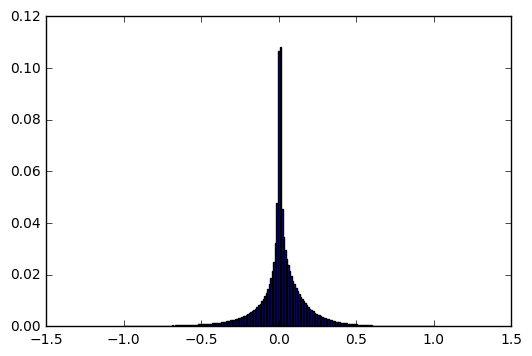

Entropy of distribution: 5.69632940306


In [31]:
hist = np.histogram(scalars, bins = np.linspace(-1.0, 1.0, NBINS + 1))
sample_hist_probs = hist[0].astype('float32')
sample_hist_bins = hist[1].astype('float32')
sample_hist_probs /= np.sum(sample_hist_probs)

sample_hist_width = 1 * (sample_hist_bins[1] - sample_hist_bins[0])
sample_hist_centers = (sample_hist_bins[:-1] + sample_hist_bins[1:]) / 2
plt.bar(sample_hist_centers, sample_hist_probs, align='center', width=sample_hist_width)
plt.show()

entropy = 0
for i in sample_hist_probs:
    if (i < 1e-4): continue
    entropy += i * math.log(i, 2)
entropy = -entropy
print "Entropy of distribution:", entropy

In [32]:
[rate, data] = sciwav.read("./SA1.WAV")
data = data.astype(np.float32)
processedWave, wparams = preprocessWaveform(data)
windows = extractWindows(processedWave, STEP_SIZE, OVERLAP_SIZE)

transformed, tparams = preprocessWindows(windows)

transformed = np.reshape(transformed, (transformed.shape[0], WINDOW_SIZE, 1))
embed = ac_enc.predict(transformed, batch_size = BATCH_SIZE, verbose = 1)

112/112 [==============================] - 0s


In [33]:
recons = ac_dec.predict(embed, batch_size = BATCH_SIZE, verbose = 1)
recons = unpreprocessWindows(recons, tparams)
#recons = reconstructFromWindows(recons, OVERLAP_SIZE, OVERLAP_FUNC)
#recons = unpreprocessWaveform(recons, wparams)
#recons = np.clip(recons, -32767, 32767)

112/112 [==============================] - 0s


In [34]:
idx = 44
print np.count_nonzero(embed[idx]), "nonzero"
print embed[idx]

print len(scalars)
print np.count_nonzero((abs(scalars) > 1).astype('int'))

127 nonzero
[0.160000 0.080000 -0.120000 -0.160000 -0.110000 -0.120000 0.050000
 0.180000 0.170000 0.320000 0.090000 -0.200000 -0.130000 -0.230000
 -0.250000 -0.030000 -0.060000 0.200000 0.120000 0.050000 0.060000
 -0.160000 -0.150000 -0.080000 -0.060000 0.150000 0.160000 0.250000
 0.250000 -0.120000 -0.150000 -0.120000 -0.290000 -0.100000 -0.040000
 0.060000 0.210000 0.040000 0.090000 -0.040000 -0.190000 -0.090000
 -0.100000 0.030000 0.170000 0.160000 0.300000 0.060000 -0.170000 -0.100000
 -0.210000 -0.210000 -0.040000 -0.050000 0.180000 0.110000 0.070000
 0.060000 -0.130000 -0.130000 -0.130000 -0.050000 0.090000 0.140000
 0.210000 0.270000 -0.040000 -0.140000 -0.110000 -0.210000 -0.160000
 -0.020000 0.000000 0.190000 0.080000 0.080000 0.030000 -0.150000 -0.110000
 -0.150000 -0.040000 0.090000 0.120000 0.180000 0.250000 0.020000 -0.150000
 -0.090000 -0.190000 -0.170000 -0.010000 -0.030000 0.170000 0.090000
 0.070000 0.060000 -0.110000 -0.130000 -0.120000 -0.110000 0.060000
 0.080000 0

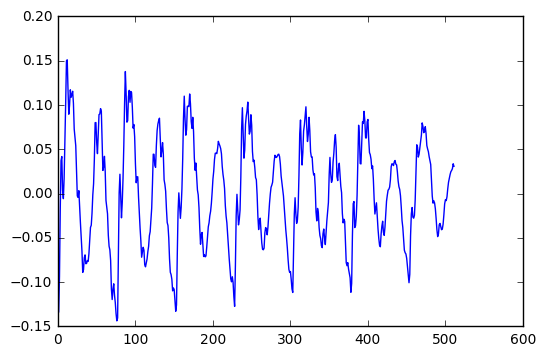

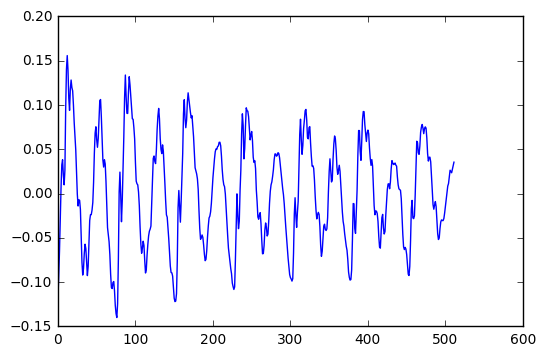

In [36]:
idx = 56

plt.plot(windows[idx])
plt.show()
plt.plot(recons[idx])
plt.show()